# Line Detection

#### Basics of Houghline Method
A line can be represented as `y = mx + c` or in parametric form, as `rho = xcos (theta) + ysin (theta)` 
* Rho is the perpendicular distance from origin to the line
* Theta is the angle formed by this perpendicular line and horizontal axis measured in counter-clockwise.
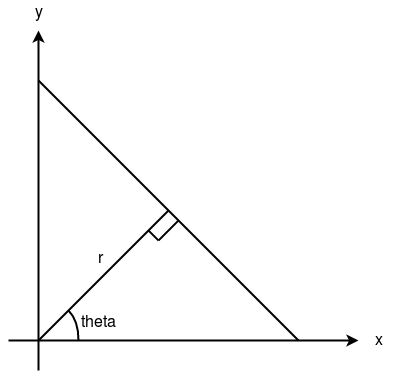

### Algorithm

1. Convert Image to Grayscale
2. Apply Gaussian blur to reduce noise
3. Perform Canny edge detection

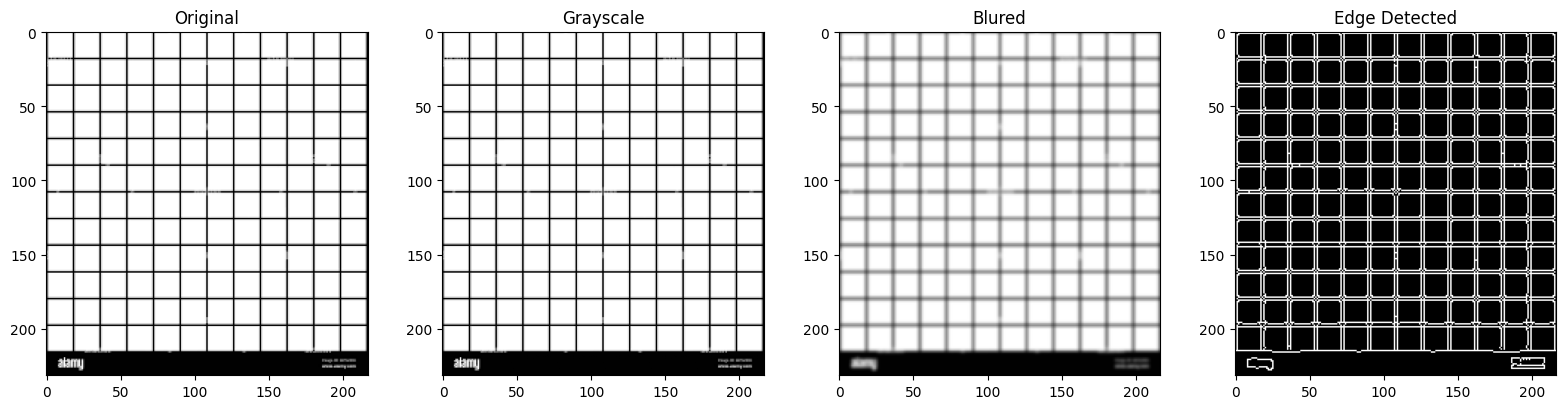

In [2]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

# Important parameters
num_rho = 180
num_theta = 180

# Read image
image = cv2.imread(r'E:\Rawan\Projects\Computer Vision\Task2ClarityEdgeAndShapeDetection\Task2-Contours-of-Clarity-Edge-and-Shape-Detection\pyQt\data\grid.png')

#Apply Canny Edge Detection
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blured_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
edged_image = cv2.Canny(blured_image, 50, 150)

# Display all images
plt.figure(figsize=(16,4))
plt.subplot(141), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original')
plt.subplot(142), plt.imshow(gray_image, cmap='gray'), plt.title('Grayscale')
plt.subplot(143), plt.imshow(cv2.cvtColor(blured_image, cv2.COLOR_BGR2RGB)), plt.title('Blured')
plt.subplot(144), plt.imshow(edged_image, cmap='gray'), plt.title('Edge Detected')
plt.tight_layout()
plt.show()

4. #### Working of Houghline Method
    1. **Initialization**
        * **Accumulator Array:** 
            * Create a 2D NumPy array of zeros
            * Size determined by num_rhos × num_thetas
            * Rows represent rho values (distance from the origin to the detected line)
            * Columns represent theta values (angle between the rho and the x-axis)
        * **Theta Values:**
            * Create an array of thetas with a range of values from 0 to 180 degrees w, with step of dtheta
        * **Rho Values:**
            * Create an array of both positive and negative rhos with a range of values from -image_diagonal to image_diagonal, with step of drho

In [3]:
# Image dimensions
height, width = edged_image.shape[:2]
half_height, half_width = height / 2, width / 2
print("height, width:", height,",", width)
print("half height, half width:", half_height,",", half_width)

# Calculate diagonal length and steps (resolution)
diagonal = int(math.sqrt(height**2 + width**2))
dtheta = 180 / num_theta
drho = (2 * diagonal) / num_rho
print("diagonal: ", diagonal)
print("rho_step, theta_step: ", drho,",", dtheta)

# Create theta and rho ranges
thetas = np.arange(0, 180, step=dtheta)
rhos = np.arange(-diagonal, diagonal, step=drho)
print("rhos shape, thetas shape: ",rhos.shape, ",", thetas.shape)
print("rhos: ",rhos[0:5], rhos[-5:])
print("thetas: ",thetas[0:5], thetas[-5:])

# Initialize accumulator
accumulator = np.zeros((len(rhos), len(thetas)))
print("accumulator shape: ", accumulator.shape)
print("accumulator: ", accumulator[0, 0:5], accumulator[0, -5:])

height, width: 232 , 217
half height, half width: 116.0 , 108.5
diagonal:  317
rho_step, theta_step:  3.522222222222222 , 1.0
rhos shape, thetas shape:  (180,) , (180,)
rhos:  [-317.         -313.47777778 -309.95555556 -306.43333333 -302.91111111] [299.38888889 302.91111111 306.43333333 309.95555556 313.47777778]
thetas:  [0. 1. 2. 3. 4.] [175. 176. 177. 178. 179.]
accumulator shape:  (180, 180)
accumulator:  [0. 0. 0. 0. 0.] [0. 0. 0. 0. 0.]


2. **Voting Process**
    * Iterate through each edge point (x, y).
    * For each edge point:
        * Shift origin from top-left to image center allowing for both positive and negative rhos.
        * Iterate through all theta values.
        * Calculate rho using the formula: `rho = x * cos(theta) + y * sin(theta)`.
        * Round rho to the nearest integer.
        * Increment the accumulator at the corresponding (rho, theta) index.

Accumulator shape: (180, 180)
Non-zero elements: 14365
Maximum vote count: 467.0

First few non-zero elements:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


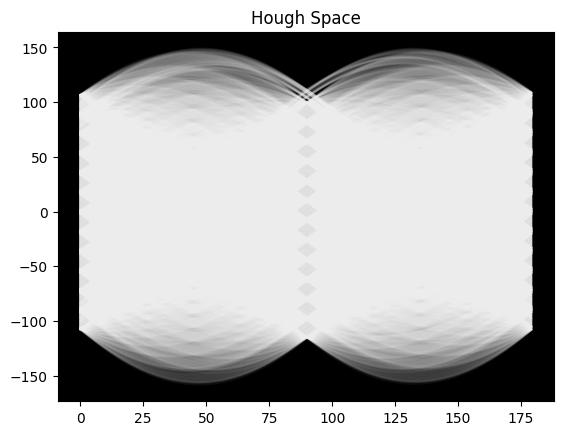

In [4]:
# Precompute trig values
cos_thetas = np.cos(np.deg2rad(thetas))
sin_thetas = np.sin(np.deg2rad(thetas))

# Setup Hough space visualization
figure = plt.figure()
hough_plot = figure.add_subplot()
hough_plot.set_facecolor((0, 0, 0))
hough_plot.title.set_text("Hough Space")

for y in range(height):
    for x in range(width):
        if edged_image[y, x] != 0:
            center = [y - half_height, x - half_width]

            # Initialize rhos and thetas for hough space visualization
            hough_rhos, hough_thetas = [], []

            for theta_idx in range(len(thetas)):
                rho = (center[1] * cos_thetas[theta_idx]) + (center[0] * sin_thetas[theta_idx])
                theta = thetas[theta_idx]
                rho_idx = np.argmin(abs(rhos - rho))
                accumulator[rho_idx] [theta_idx] += 1

                hough_rhos.append(rho)
                hough_thetas.append(theta)

            hough_plot.plot(hough_thetas, hough_rhos, color="white", alpha=0.05)

print("Accumulator shape:", accumulator.shape)
print("Non-zero elements:", np.count_nonzero(accumulator))
print("Maximum vote count:", np.max(accumulator))
print("\nFirst few non-zero elements:")
print(accumulator[accumulator > 0][:10])

3. **Finding Peaks**
    * Find the local maxima in the accumulator array. 

In [5]:
# Find local maxima in accumulator
max_val = np.max(accumulator)

# Find the indices of the maximum value
max_idx = np.unravel_index(np.argmax(accumulator), accumulator.shape)
max_rho = rhos[max_idx[0]]
max_theta = thetas[max_idx[1]]

print(f"Maximum value in accumulator: {max_val}")
print(f"(rho, theta) = ({max_rho:.2f}, {max_theta:.2f}°)")

Maximum value in accumulator: 467.0
(rho, theta) = (0.00, 0.00°)


4. **Drawing Lines**
    * For each detected (rho, theta) pair:
        * Calculate two points on the line using the same logic as in the OpenCV example.
        * Draw the line on the original image.

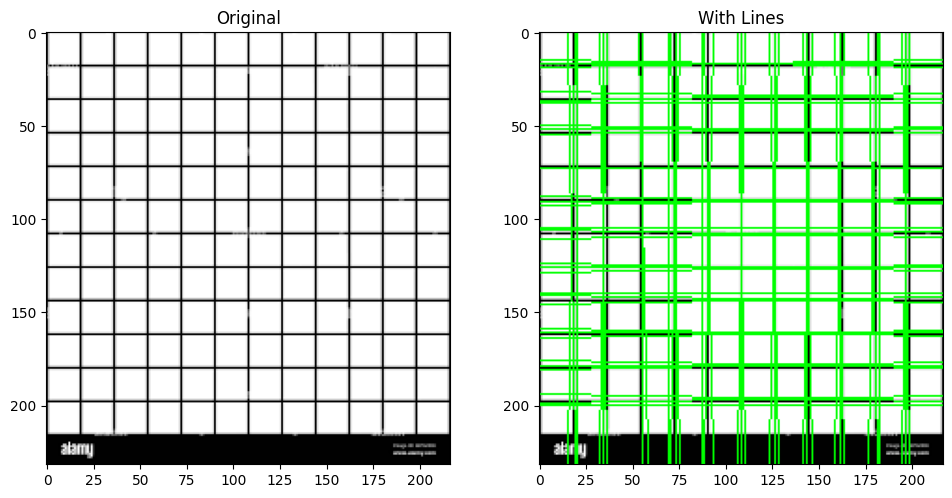

In [7]:
# Dynamic threshold based on maximum value
threshold = max_val * 0.6

# Detect lines from accumulator
output_image = image.copy()

for y in range(accumulator.shape[0]):
    for x in range(accumulator.shape[1]):
        if accumulator[y][x] > threshold:
                rho = rhos[y]
                theta = thetas[x]

                a = np.cos(np.deg2rad(theta))
                b = np.sin(np.deg2rad(theta))

                # The nearest point on the line from the center.
                x0 = (a * rho) + half_width
                y0 = (b * rho) + half_height

                # The two endpoints of the line, one in each direction.
                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))

                output_image = cv2.line(output_image, (x1,y1), (x2,y2), (0,255,0), 1)

# Create a single figure for all plots
plt.figure(figsize=(10,5))

# First subplot: Original image
plt.subplot(121)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original')

# Second subplot: Image with lines
plt.subplot(122)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title('With Lines')

plt.tight_layout()
plt.show()